In [1]:
import scanpy as sc
import pandas as pd
import sys
sys.path.append("../")

## Example 1: Single-timepoint modeling

In [2]:
import echidna as ec
ec.pl.activate_plot_settings()

/Users/mingxuanzhang/anaconda3/envs/work3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Echidna leverages single-cell and copy number data. In this example, we will use data captured from a patient during the course of anti-PD-1 therapy. The single cell file contains cell-type annotations and a label for the timepoint. Cell-type annotations are not necessary for Echidna to work, though they may be helpful for later analysis. The copy number data is from the WGS of the patient. We have mapped genes to chromosome regions and assigned weighted copy numbers according to the overlap with a given region, thus the continuous nature of the data below. Echidna assumes that copy number is generated from a truncated normal distribution so that we can treat it as a continuous variable.

In [3]:
adata = sc.read_h5ad("../../Data/echidna3/Tumor2_X.h5ad")
wdf = pd.read_csv(
    "../../Data/echidna3/tumor2_processed_w.csv",
    names=["index", "gene", "counts"], 
    header=0,
).set_index("gene").drop("index", axis=1)

In [4]:
# # Note: Make sure W is uniquely indexed
wdf.head()

,counts
gene,
MIR1302-2HG,1.06135
FAM138A,1.06135
OR4F5,1.06135
AL627309.1,1.06135
AL627309.3,1.06135


In [5]:
matched_genes = adata.var.index.intersection(wdf.index)
wdf = wdf.loc[matched_genes]
adata = adata[:, matched_genes]
wdf = wdf.loc[~wdf.index.duplicated(keep=False)]
adata = adata[:, wdf.index]

Pre-process your data if necessary. I've already run this step and saved the processed AnnData. Your pre-processing should do the following:

1. Save the raw single-cell counts in a layer
2. Cluster labels for Echidna to leverage
3. Create a timepoint label

In the `EchidnaConfig`, you can tell Echidna where to look for the necessary data. Specify your timepoint column (`timepoint_label`), your cluster labels (`clusters`), and your counts layer (`counts_layer`). In the single timepoint case, you can provide a filler label, eg `adata.obs["timepoint"] = "single_tp"`. In the multi-timepoint case, Echidna will look in the column you specify in `EchidnaConfig` to know which cells were taken from which timepoint.

In [6]:
adata.obs["timepoint"] = "single_tp"

/var/folders/n0/lbm2yq4n3r1gp83zkf5s69j00000gn/T/ipykernel_22898/4069263509.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["timepoint"] = "single_tp"


In [7]:
# # Optional: filter out low variance genes
# adata = ec.tl.filter_low_var_genes(adata, quantile=0.5)

Specify the parameters for your training run, model hyperparameters, and the labels in your AnnData that Echidna should use to construct the data for modeling. See the README.md for the full list of config settings.

In [8]:
num_cells = adata.shape[1]
num_genes = adata.shape[-1]
num_clusters = len(adata.obs['leiden'].unique())
q_corr_init = 0.1
q_shape_rate_scaler = 10.0
eta_mean_init = wdf['counts'].mean()
lkj_concentration = 1.0

2024-10-19 02:36:16,927 | INFO : Added `.obs['echidna_split']`: the Echidna train/validation split.
 233 cells in validation set.
2024-10-19 02:36:16,930 | INFO : Added `.var[echidna_matched_genes]` : Labled True for genes contained in W.
training loss: 0.1458 | validation loss: 0.0272: 100%|██████████| 500/500 [01:44<00:00,  4.79it/s]


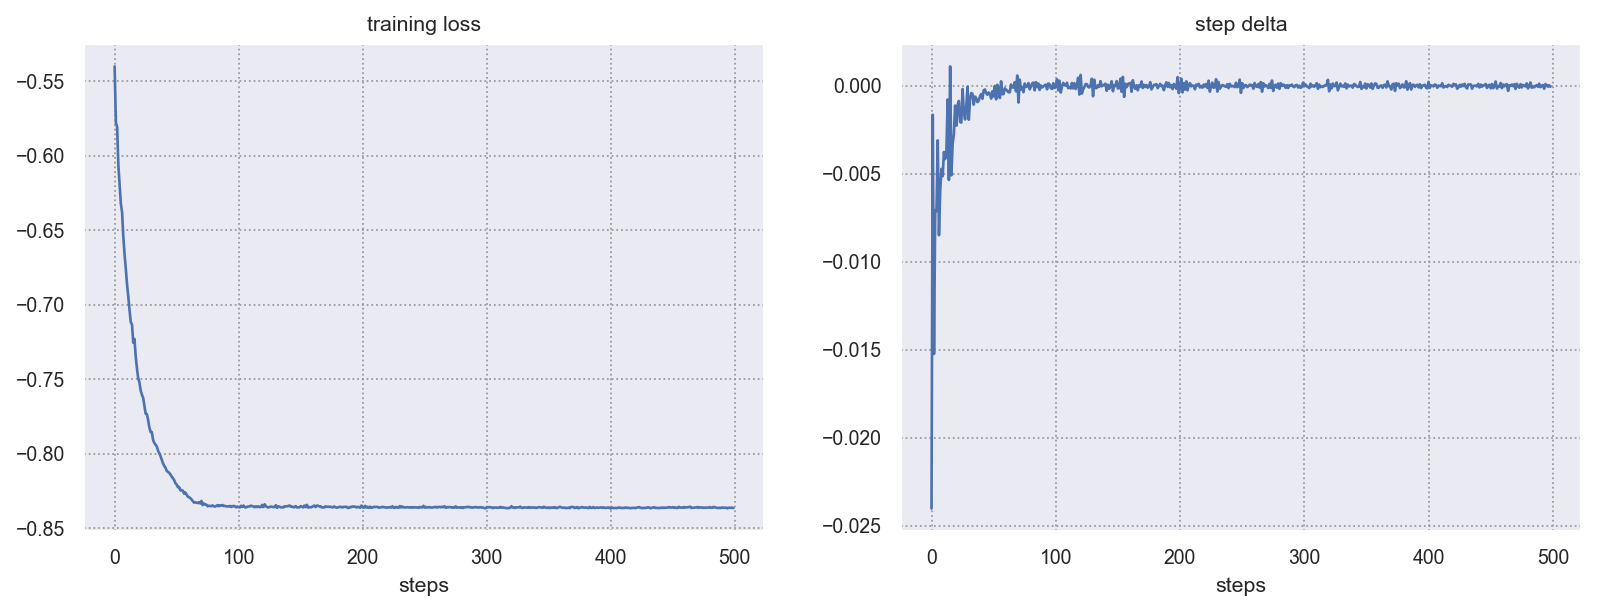

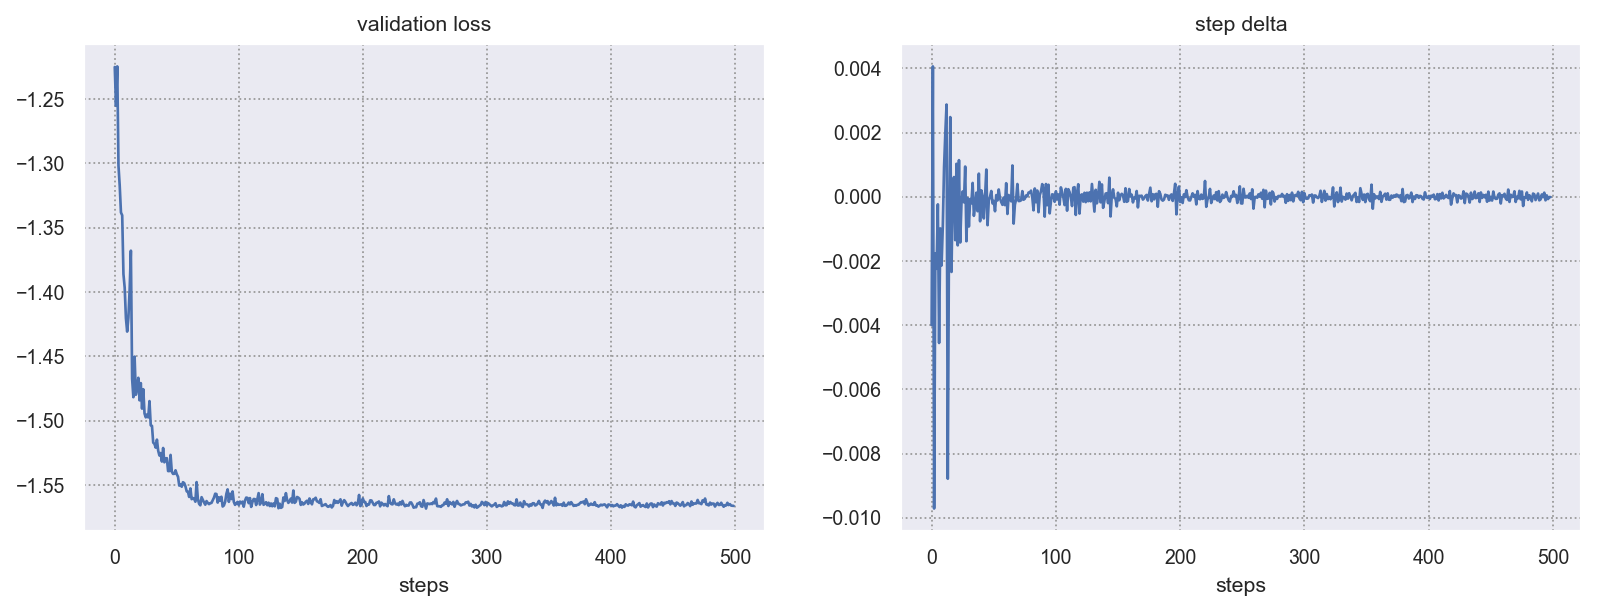

2024-10-19 02:38:32,904 | INFO : Overwriting existing echidna model.


In [29]:
config = ec.tl.EchidnaConfig(
    timepoint_label = "timepoint", # `assert 'timepoint' in adata.obs.columns`
    counts_layer = "counts", # `assert 'counts' in list(adata.layers.keys())`
    clusters = "leiden", # `assert 'leiden' in adata.obs.columns`
    inverse_gamma = True, # Inverse Gamma can be more stable in low data settings
    eta_mean_init = eta_mean_init, # Our genes average approximately two copies
    q_corr_init=q_corr_init,
    q_shape_rate_scaler=q_shape_rate_scaler,
    lkj_concentration=lkj_concentration,
    patience = 500, # turn off early stopping
    n_steps = 500, # Passes through the dataset
)
ec.tl.echidna_train(
     adata # single cell anndata
    , wdf.loc[:,"counts"] # Copy number pd.DataFrame, indexed with genes. Select for "on" timepoint.
    , config # config settings
)

Using our learned model, we do a hierarchical clustering of our posteriror $\eta_k$ to get latent clusters. You may choose to estimate distances between clones at the covariance or correlation level. Echidna defaults to correlation, but covariance can be used with boolean parameter `cov=True`. You may elect between the "elbow", "cophenetic", or "manual" method of thresholding the linkage. Specifying the `threshold` parameter (float) overrides any method as "manual".

In [30]:
ec.tl.echidna_clones(adata, method='manual', metric="smoothed_corr", threshold=0.3)

2024-10-19 02:39:00,136 | INFO : Added `.obs['echidna_clones']`: the learned clones from eta.


You may opt to visualize results with U-MAP coordinates, in order to upset many researchers:

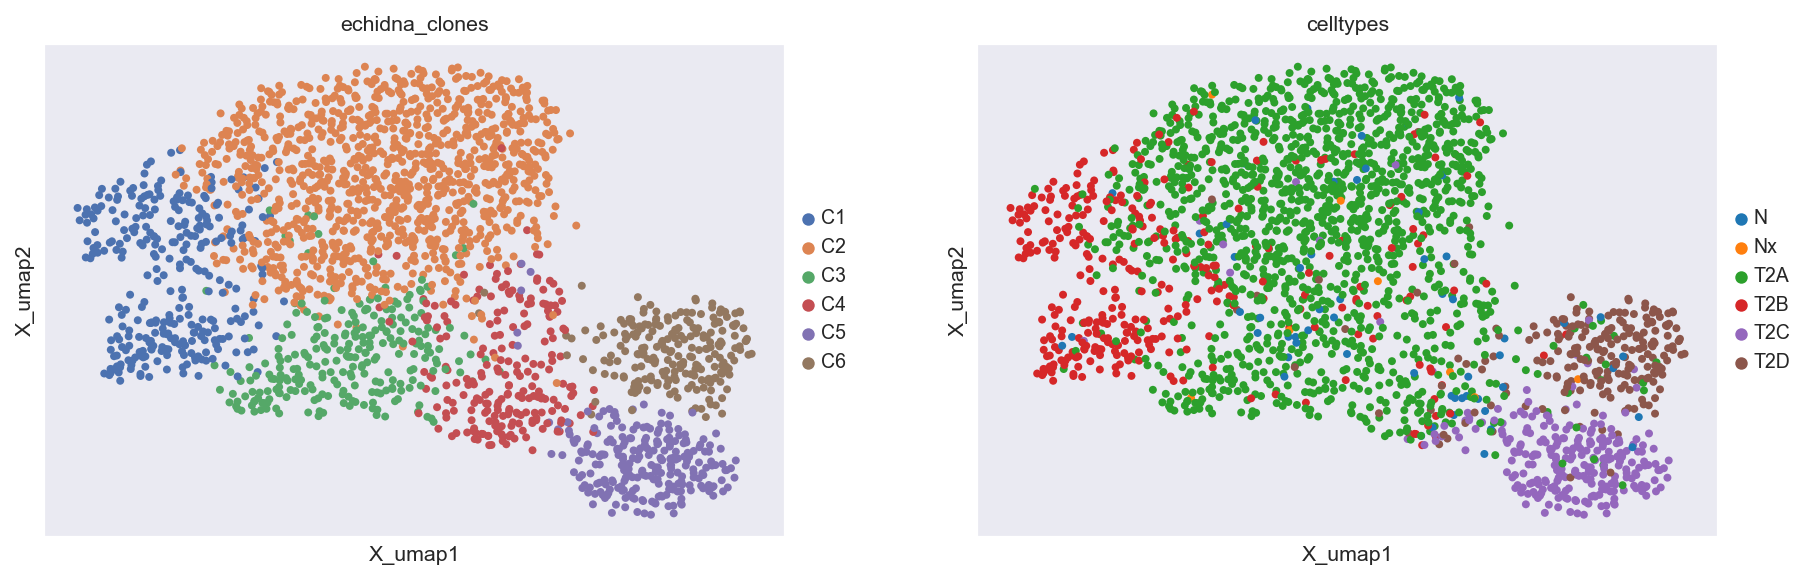

In [32]:
ec.pl.echidna(adata, ["echidna_clones", "celltypes"])

Echidna provides convenient functions for doing posterior predictive checks (ppc) to ensure your model is able to properly generate data. A sample of "X" for example, should look similar in distribution to the original observed data.

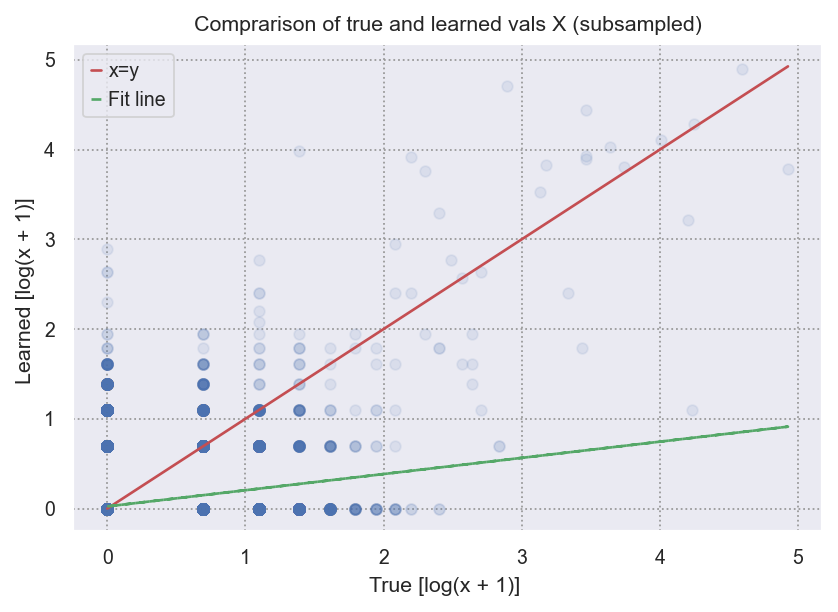

In [34]:
ec.pl.ppc(adata, "X")

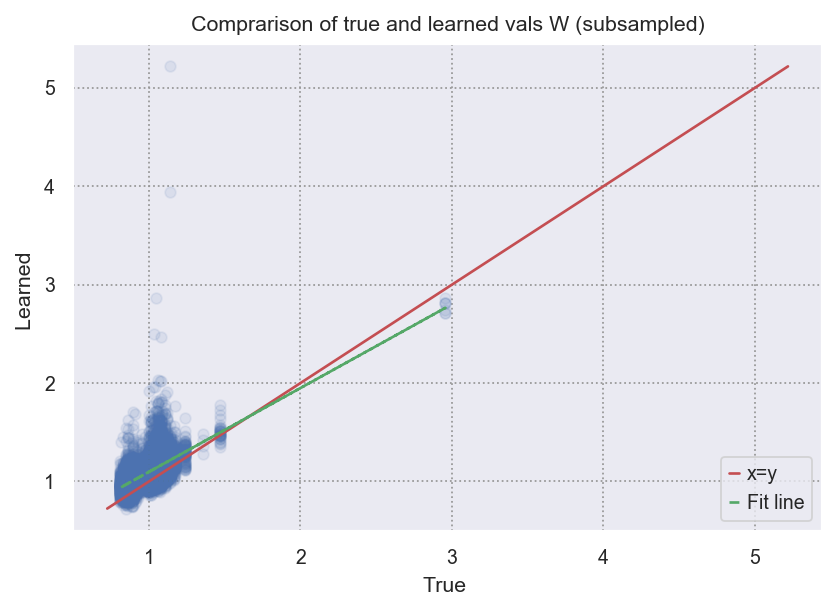

In [35]:
ec.pl.ppc(adata, "W")

To do a posterior predictive check on our latent variables, you need to simulate data from your model by training a model on a sampled X and W. This function will save a simulated version of the model for you, and will use that simulated model to do the posterior predictive check on "eta", the covariance of eta "cov", and on "c".

training loss: 0.1420 | validation loss: 0.0235: 100%|██████████| 500/500 [01:37<00:00,  5.14it/s]


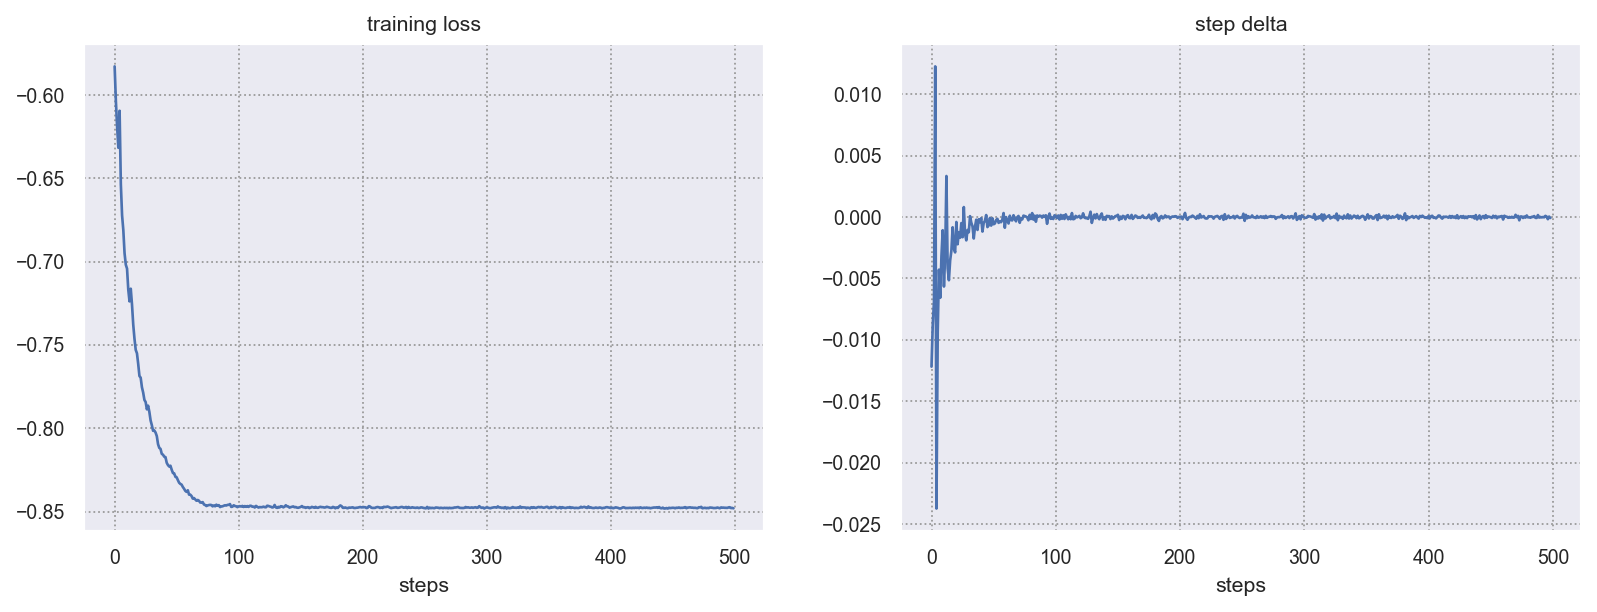

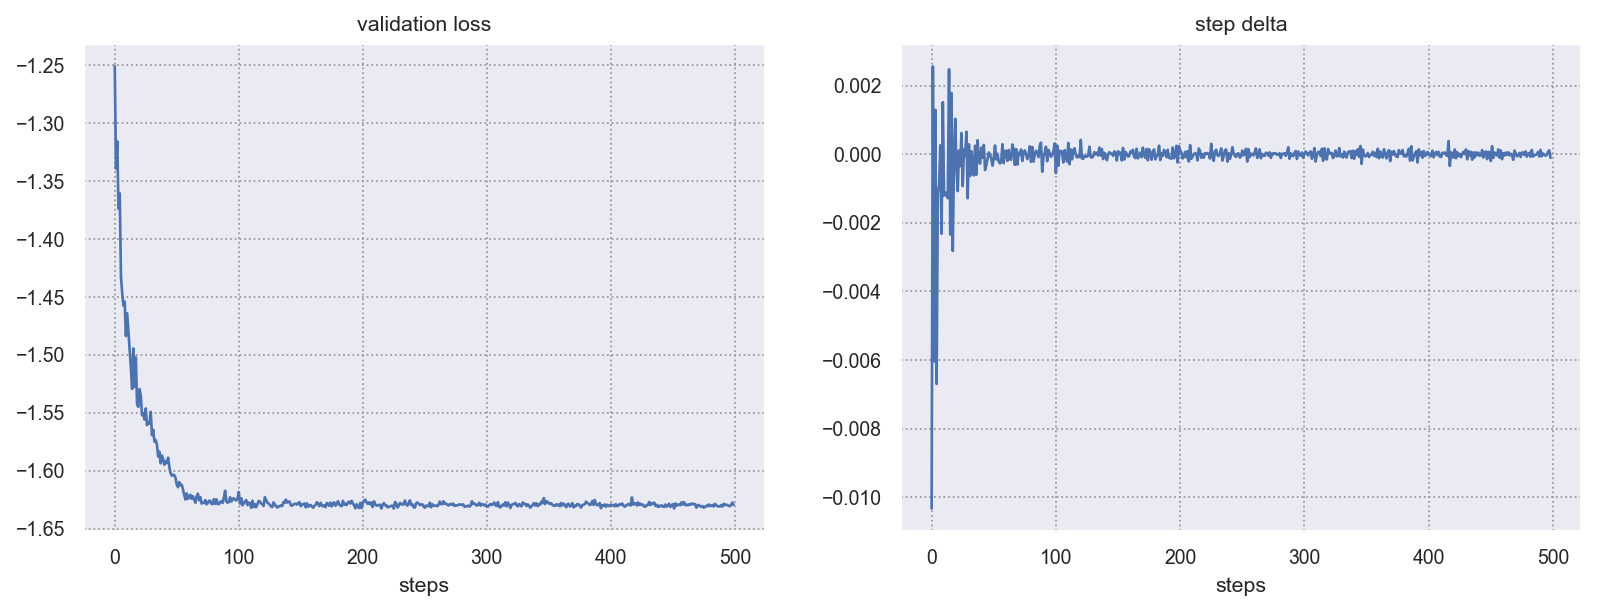

2024-10-19 02:42:05,038 | INFO : Overwriting existing echidna simulation model.


In [36]:
ec.tl.simulate(adata)

The distance between covariance learned from our original observed data and that of simulated covariance can be visualized with boolean kwarg `difference=True`.

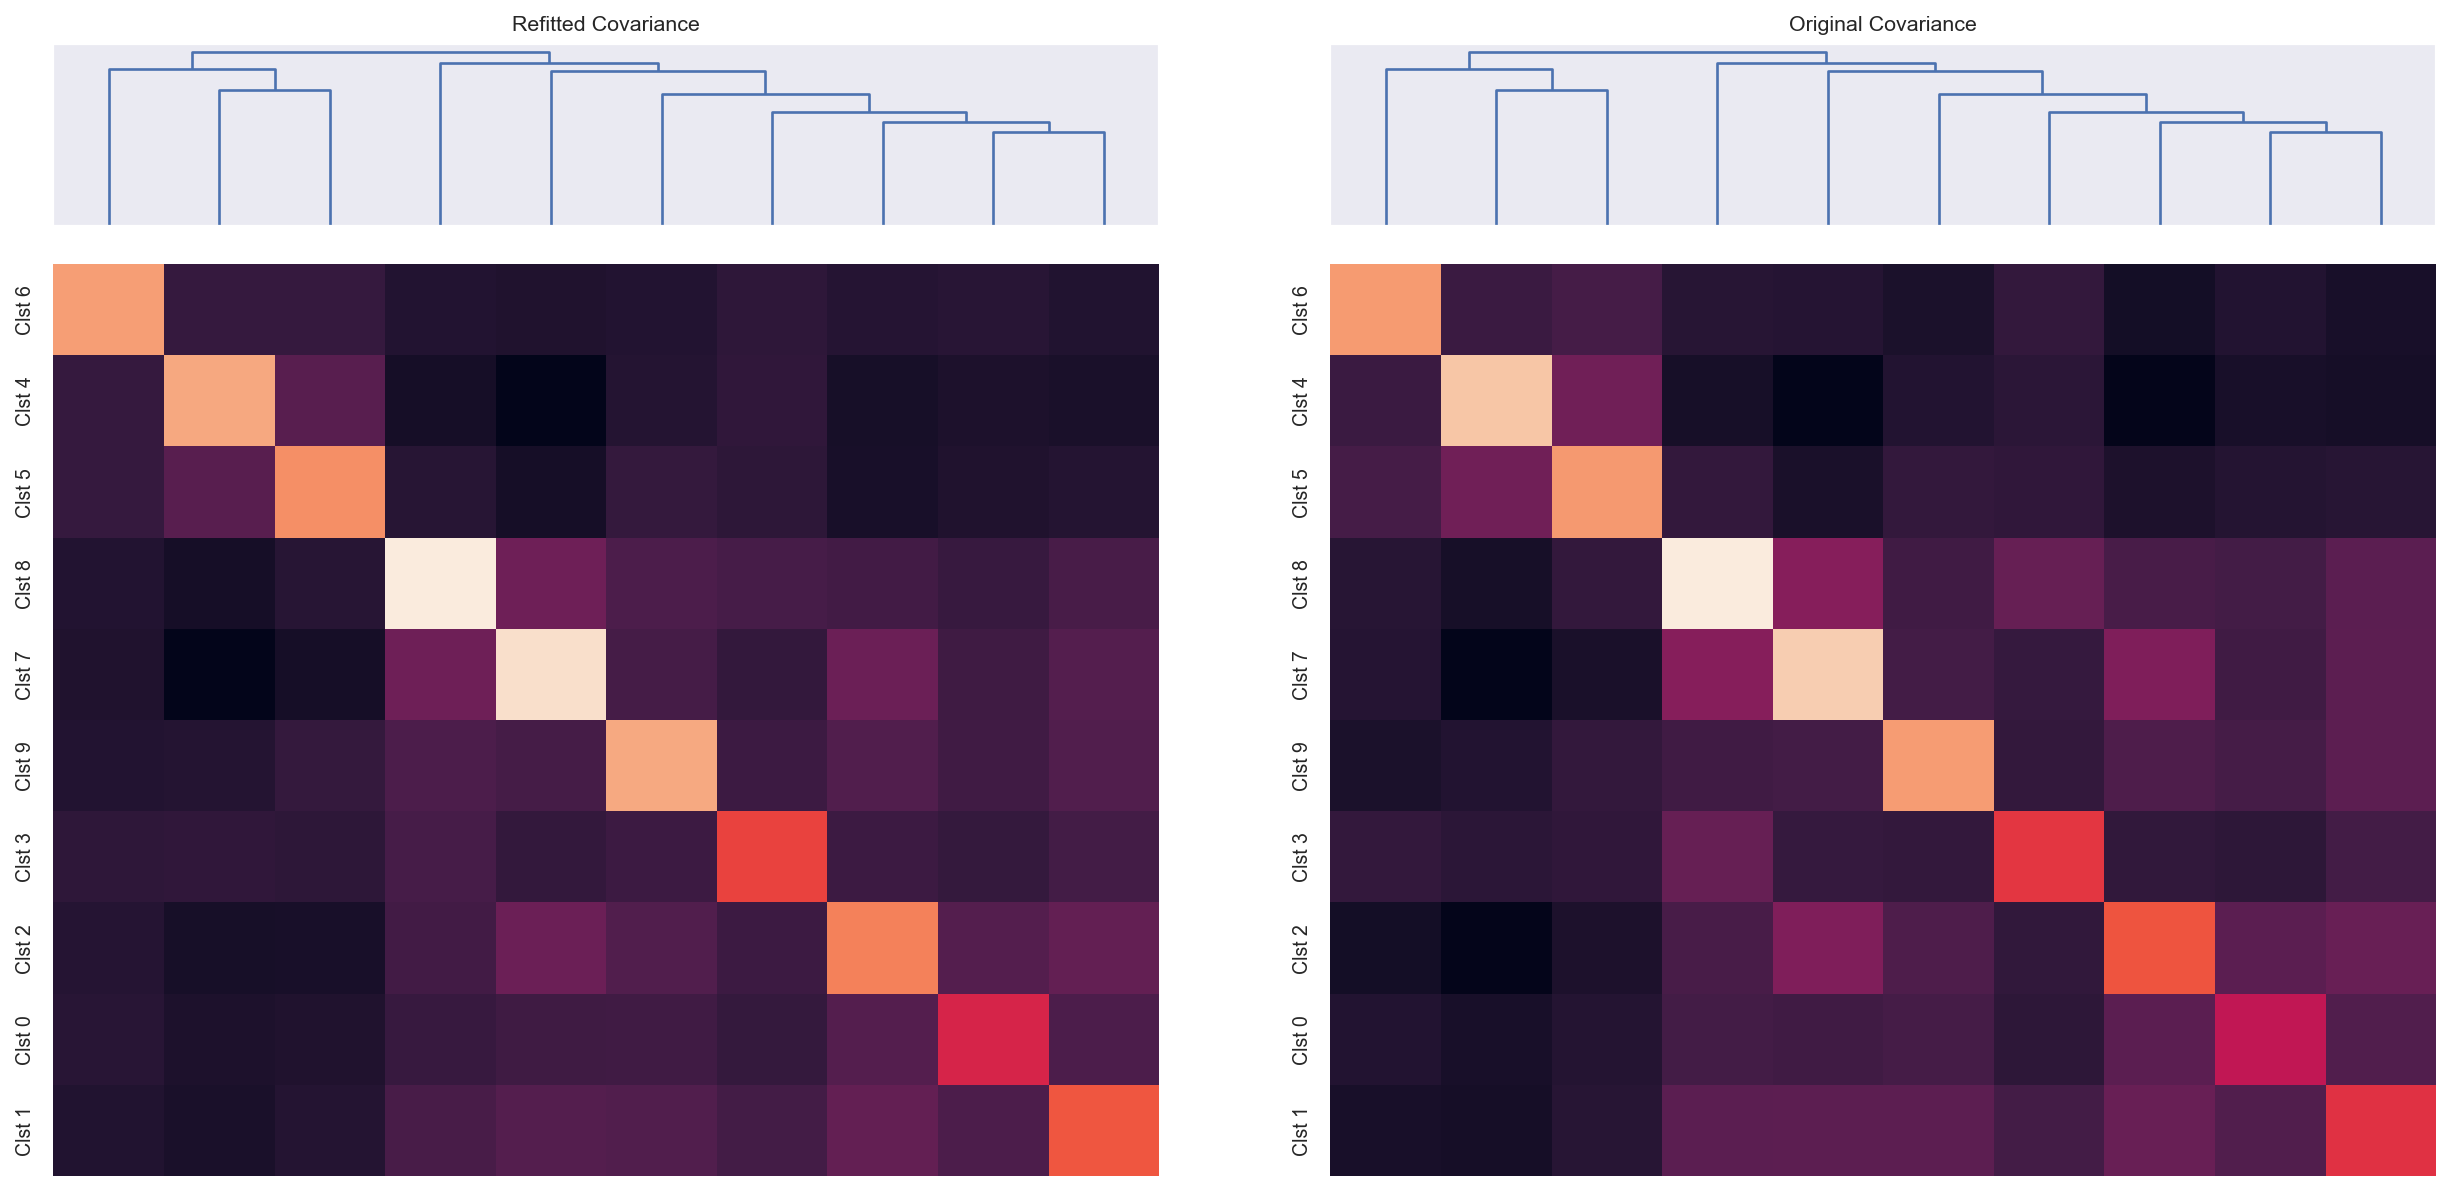

In [37]:
ec.pl.ppc(adata, "cov")

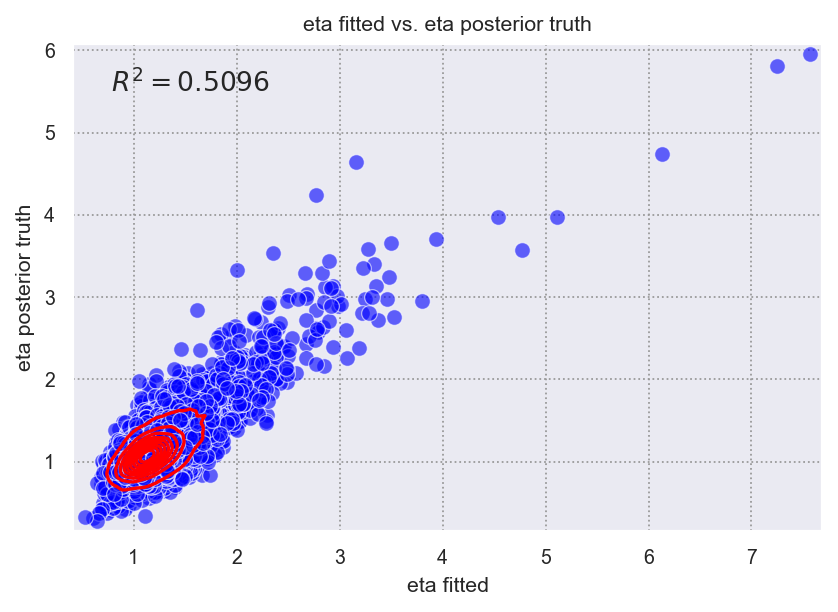

In [38]:
ec.pl.ppc(adata, "eta")

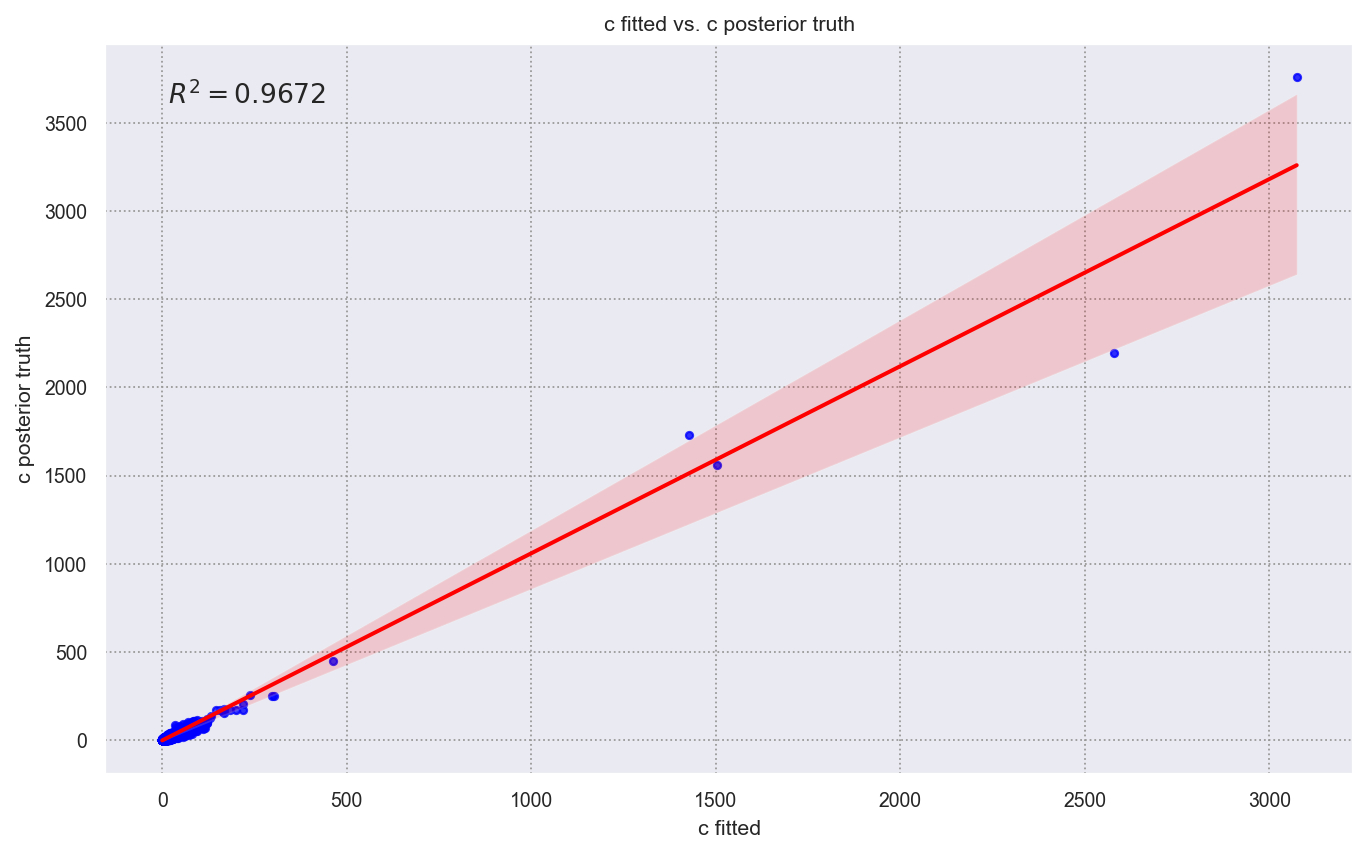

In [39]:
ec.pl.ppc(adata, "c")

Echidna also provides tools for conveniently sampling from the model. The second argument `variable` must be one of or a list of "X", "W", "c", "eta", "cov".

In [40]:
ec.tl.sample(adata, ["X", "W"])

[tensor([[0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([0.9165, 1.0689, 1.0914,  ..., 0.8848, 0.9518, 0.9557])]

In [41]:
ec.tl.sample(adata, "eta")

tensor([[0.8650, 1.3383, 1.2548,  ..., 0.9322, 1.8333, 0.7969],
        [1.1769, 0.5076, 1.1461,  ..., 1.1666, 0.4001, 0.5328],
        [0.6736, 1.4428, 1.3583,  ..., 1.2599, 0.5527, 0.7109],
        ...,
        [0.7866, 1.0025, 0.9355,  ..., 1.2464, 1.3229, 1.0459],
        [1.2352, 0.8048, 0.4034,  ..., 0.5102, 0.8899, 0.6392],
        [1.6151, 1.5301, 1.2975,  ..., 1.7443, 1.8172, 1.1022]])

To verify the CNV deconvolution and clone structures we bin Echidna's $\eta$ and compare with matching scDNA data:

In [69]:
DNA = pd.read_csv("../../Data/echidna3/DNA_bin_counts_matrix.txt", sep='\t')

first extract barcodes of cells with matching DNA and RNA measurements

In [65]:
barcodes = list(adata.obs_names)
for i in range(len(barcodes)):
    barcodes[i] = barcodes[i].split("_")[0]
barcodes_overlap = set(barcodes).intersection(set(DNA.columns))

bin and process $\eta$ and DNA for plotting

In [66]:
import numpy as np

In [49]:
model = ec.tl.housekeeping.load_model(adata) # load a trained echidna model

In [74]:
DNA = DNA[barcodes]
DNA = DNA / np.array(DNA).mean(axis=0) * 2 # THIS STEP IS DESCRIBED IN THE PUBLISHED PAPER THIS DATA CAME FROM
map = pd.read_csv("../../Data/echidna3/bin-boundaries and genes.txt",sep='\t')

eta = model.eta_posterior
eta_df = pd.DataFrame(eta.cpu().detach().numpy())
eta_df.columns = adata.var_names

DNA_clus = pd.DataFrame()
for cluster in eta_df.index:
    DNA_cluster = []
    obs = adata.obs
    for i in range(10):
        inds = obs[obs["leiden"]==i].index
        inds = [i.split("_")[0] for i in inds]
        DNA_cluster.append(list(DNA[inds].mean(axis=1)))
    
    DNA_cluster = pd.DataFrame(DNA_cluster)
    
    gene_names = []
    W1 = []
    for i in range(DNA_cluster.shape[1]):
        genes = str.split(map.iloc[i]["genes"],",")
        gene_names+=genes
        W1+=[DNA_cluster.loc[cluster][i] for j in range(len(genes))]

    DNA_clus[cluster] =  W1
DNA_clus.index = gene_names

In [76]:
# helper function for binning
def binning(df):
    binned = []
    discard_bins = []
    for id, row in map.iterrows():
        genes = str.split(row['genes'],",")
        overlap = list(set(df.columns).intersection(set(genes)))
        in_bin = df[overlap]
        if np.array(in_bin).shape[1] == 0:
            discard_bins.append(id)
            continue
        bin_col = np.array(in_bin).mean(axis=1)
        binned.append(bin_col.reshape(-1, 1))
    binned = np.concatenate(binned, axis=1)
    return binned, discard_bins

In [77]:
eta_binned, discard_bins = binning(eta_df)
valid_bins = [bin for bin in list(DNA_cluster.columns) if bin not in discard_bins]
DNA_cluster = DNA_cluster[valid_bins]

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: >

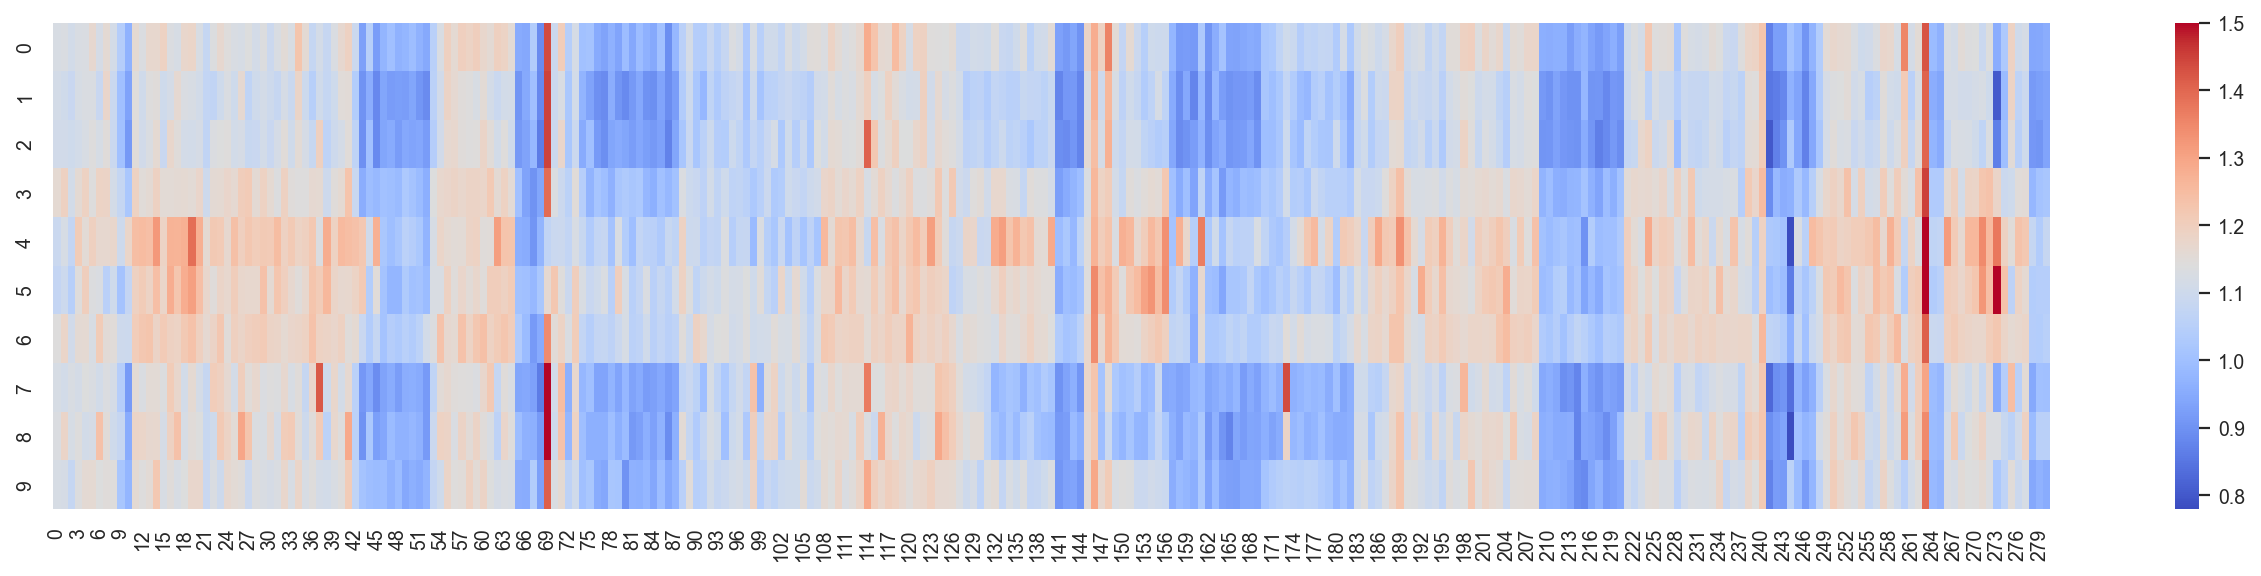

In [92]:
plt.figure(figsize=(20,4))
sns.heatmap(eta_binned, cmap='coolwarm', vmax=1.5)

<Axes: >

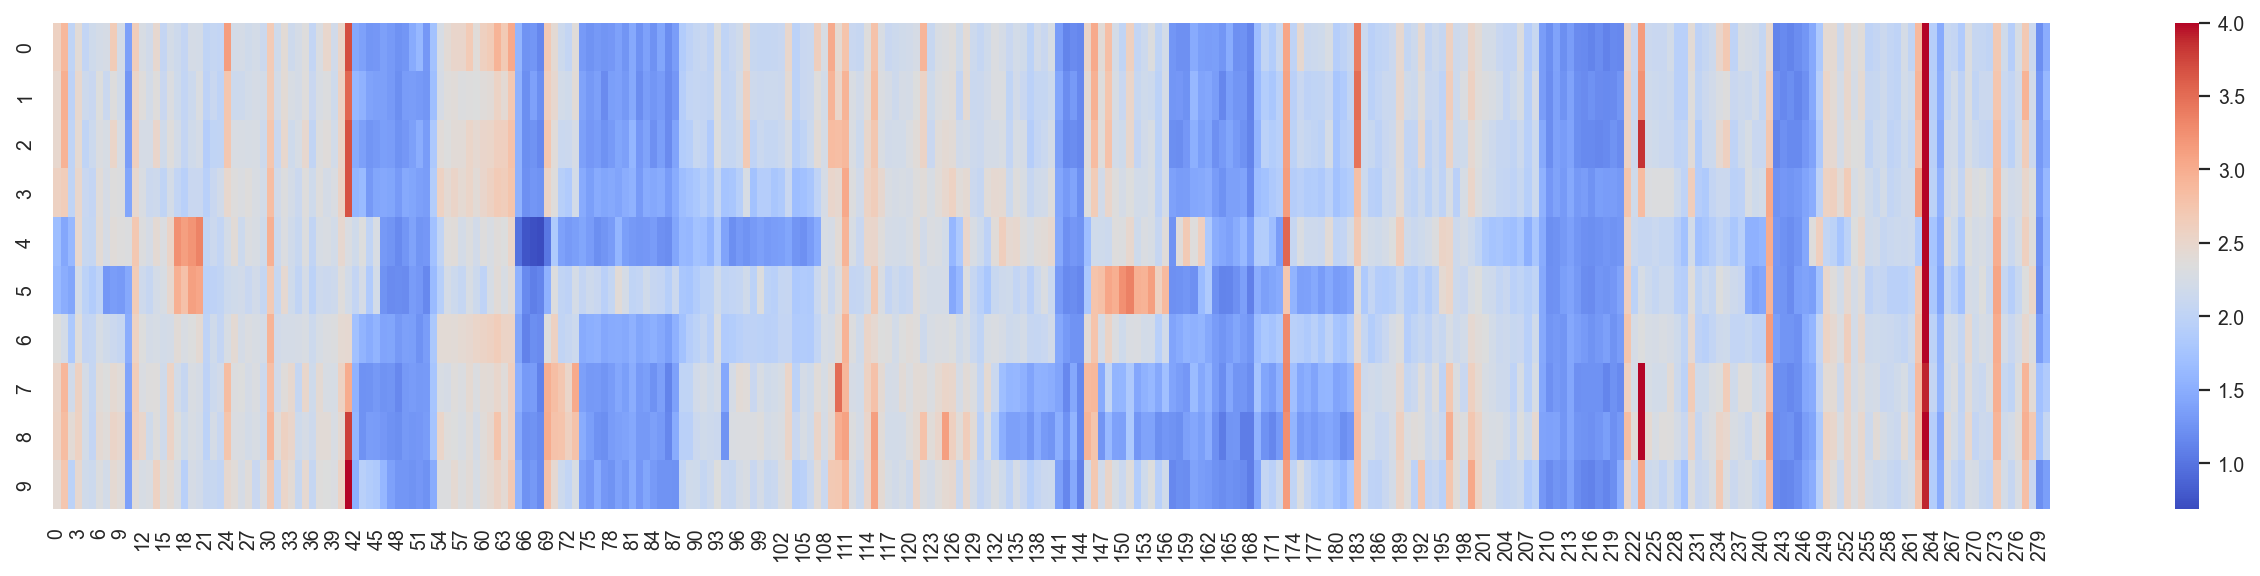

In [87]:
plt.figure(figsize=(20,4))
sns.heatmap(DNA_cluster, cmap='coolwarm', vmax=4)

To save track of the work we've done, write the AnnData object as normally, example below. The Echidna files will be saved in the present working directory (`!pwd`) of the script/notebook that runs Echidna. The AnnData contains paths to the saves, as well as a log of the config and other settings used. If you prefer to move your save data, you will find it in `"./_echidna_models/"`. I leave file management to the user.

In [27]:
# adata.write_h5ad("data/R310_ST_SAVE.h5ad")